In [1]:
%matplotlib inline



# Sleep stage classification from polysomnography (PSG) data

<div class="alert alert-info"><h4>Note</h4><p>This code is taken from the analysis code used in
          :footcite:`ChambonEtAl2018`. If you reuse this code please consider
          citing this work.</p></div>

This tutorial explains how to perform a toy polysomnography analysis that
answers the following question:

.. important:: Given two subjects from the Sleep Physionet dataset
               :footcite:`KempEtAl2000,GoldbergerEtAl2000`, namely
               *Alice* and *Bob*, how well can we predict the sleep stages of
               *Bob* from *Alice's* data?

This problem is tackled as supervised multiclass classification task. The aim
is to predict the sleep stage from 5 possible stages for each chunk of 30
seconds of data.



In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#          Joan Massich <mailsik@gmail.com>
#
# License: BSD-3-Clause

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

## Load the data

Here we download the data from two subjects and the end goal is to obtain
:term:`epochs` and its associated ground truth.

MNE-Python provides us with
:func:`mne.datasets.sleep_physionet.age.fetch_data` to conveniently download
data from the Sleep Physionet dataset
:footcite:`KempEtAl2000,GoldbergerEtAl2000`.
Given a list of subjects and records, the fetcher downloads the data and
provides us for each subject, a pair of files:

* ``-PSG.edf`` containing the polysomnography. The :term:`raw` data from the
  EEG helmet,
* ``-Hypnogram.edf`` containing the :term:`annotations` recorded by an
  expert.

Combining these two in a :class:`mne.io.Raw` object then we can extract
:term:`events` based on the descriptions of the annotations to obtain the
:term:`epochs`.

### Read the PSG data and Hypnograms to create a raw object



Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\phy00\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


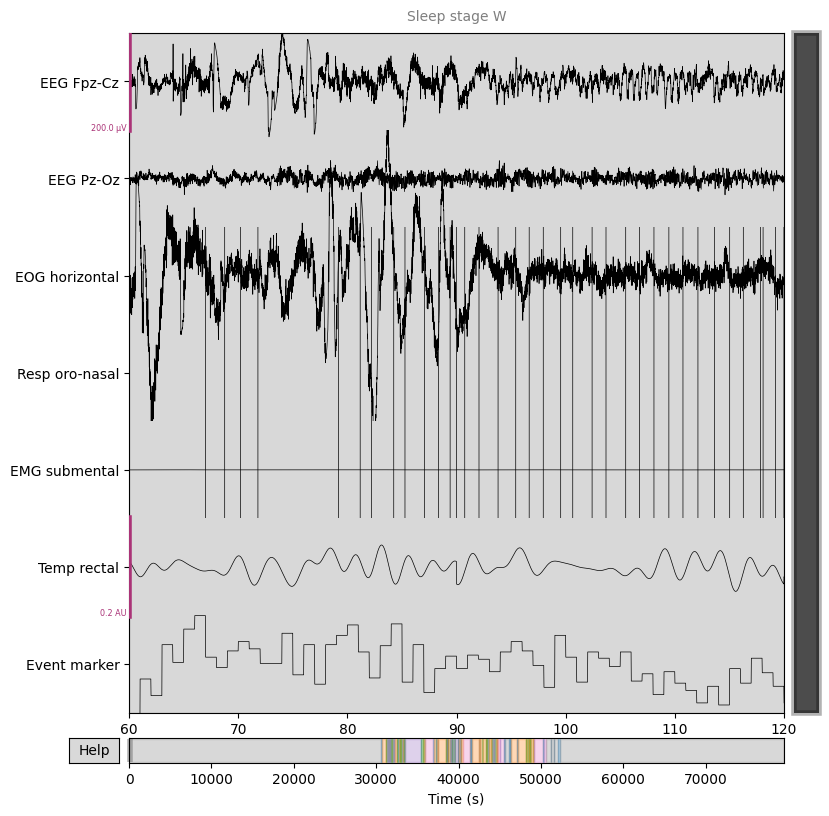

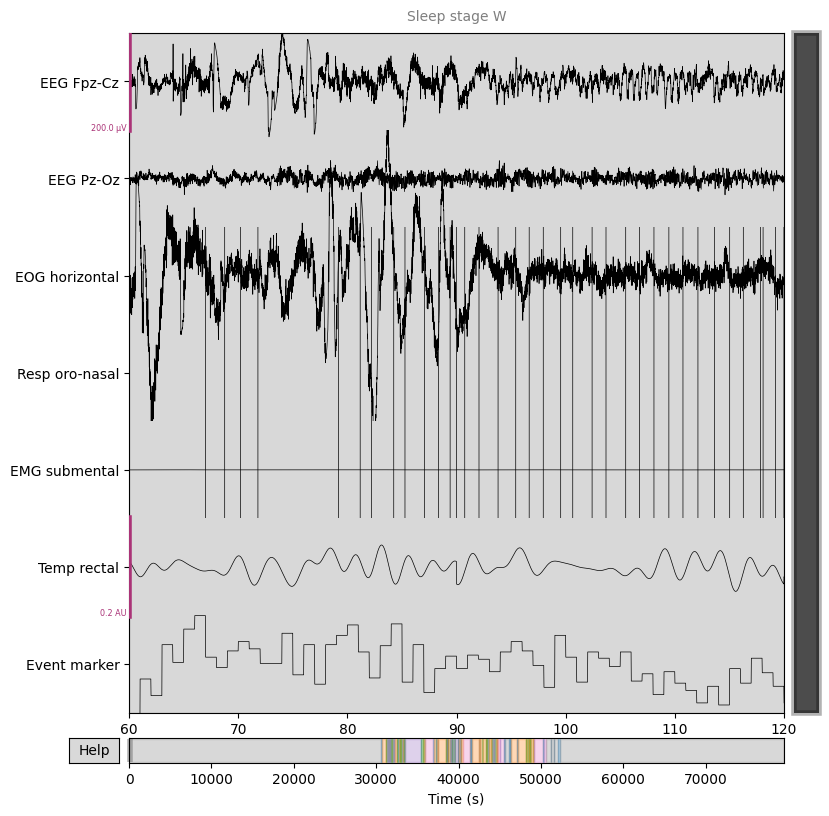

In [4]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

### Extract 30s events from annotations

The Sleep Physionet dataset is annotated using
[8 labels](physionet_labels_):
Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from
light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for
Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored
segment.

We will work only with 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and
REM sleep (R). To do so, we use the ``event_id`` parameter in
:func:`mne.events_from_annotations` to select which events are we
interested in and we associate an event identifier to each of them.

Moreover, the recordings contain long awake (W) regions before and after each
night. To limit the impact of class imbalance, we trim each recording by only
keeping 30 minutes of wake time before the first occurrence and 30 minutes
after the last occurrence of sleep stages.



Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


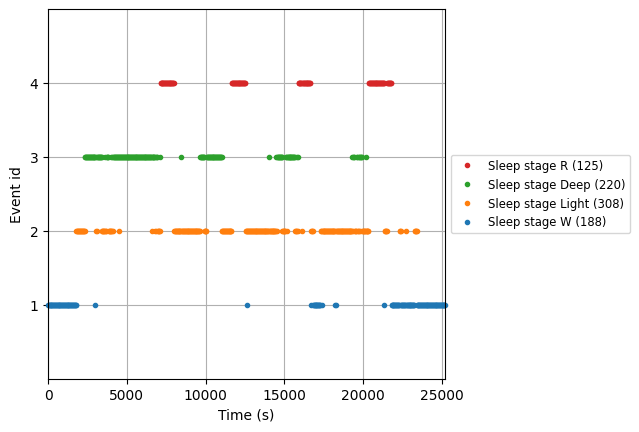

In [5]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 2,
                              'Sleep stage 3': 3,
                              'Sleep stage 4': 3,
                              'Sleep stage R': 4}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage Light': 2,
            'Sleep stage Deep': 3,
            'Sleep stage R': 4}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Create Epochs from the data based on the events found in the annotations



In [6]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage Light': 308
 'Sleep stage Deep': 220
 'Sleep stage R': 125>


### Applying the same steps to the test data from Bob



In [7]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from C:\Users\phy00\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 157
 'Sleep stage Light': 671
 'Sleep stage Deep': 105
 'Sleep stage R': 170>


## Feature Engineering

Observing the power spectral density (PSD) plot of the :term:`epochs` grouped
by sleeping stage we can see that different sleep stages have different
signatures. These signatures remain similar between Alice and Bob's data.

The rest of this section we will create EEG features based on relative power
in specific frequency bands to capture this difference between the sleep
stages in our data.



Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 308 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 105 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 671 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 170 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS 

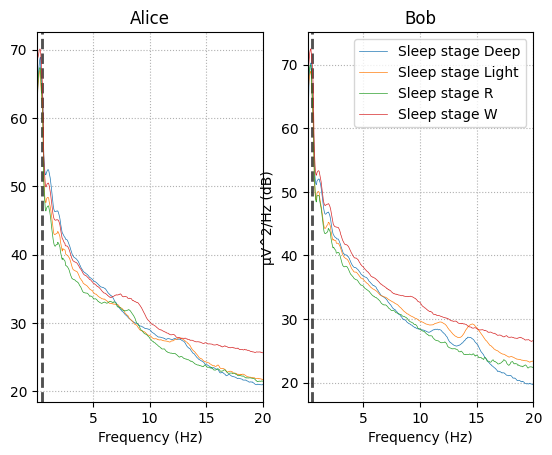

In [8]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

### Design a scikit-learn transformer from a Python function

We will now create a function to extract EEG features based on relative power
in specific frequency bands to be able to predict sleep stages from EEG
signals.



In [9]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Multiclass classification workflow using scikit-learn

To answer the question of how well can we predict the sleep stages of Bob
from Alice's data and avoid as much boilerplate code as possible, we will
take advantage of two key features of sckit-learn: `Pipeline`_ , and
`FunctionTransformer`_.

Scikit-learn pipeline composes an estimator as a sequence of transforms
and a final estimator, while the FunctionTransformer converts a python
function in an estimator compatible object. In this manner we can create
scikit-learn estimator that takes :class:`mne.Epochs` thanks to
``eeg_power_band`` function we just created.



In [10]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy score: 0.7035358114233907


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


In short, yes. We can predict Bob's sleeping stages based on Alice's data.

### Further analysis of the data

We can check the confusion matrix or the classification report.



In [11]:
print(confusion_matrix(y_test, y_pred))

[[155   1   1   0]
 [143 459  29  40]
 [  0   6  99   0]
 [ 57  50   0  63]]


In [12]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                   precision    recall  f1-score   support

    Sleep stage W       0.44      0.99      0.61       157
Sleep stage Light       0.89      0.68      0.77       671
 Sleep stage Deep       0.77      0.94      0.85       105
    Sleep stage R       0.61      0.37      0.46       170

         accuracy                           0.70      1103
        macro avg       0.68      0.75      0.67      1103
     weighted avg       0.77      0.70      0.71      1103



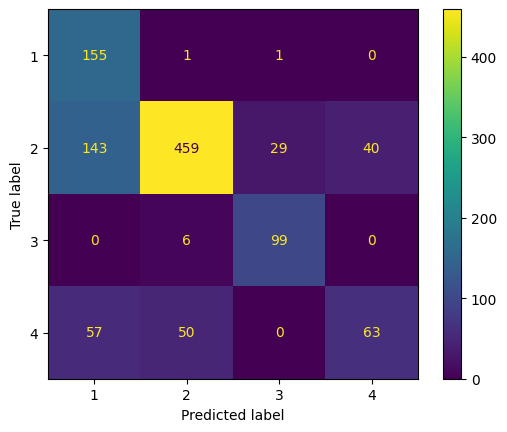

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

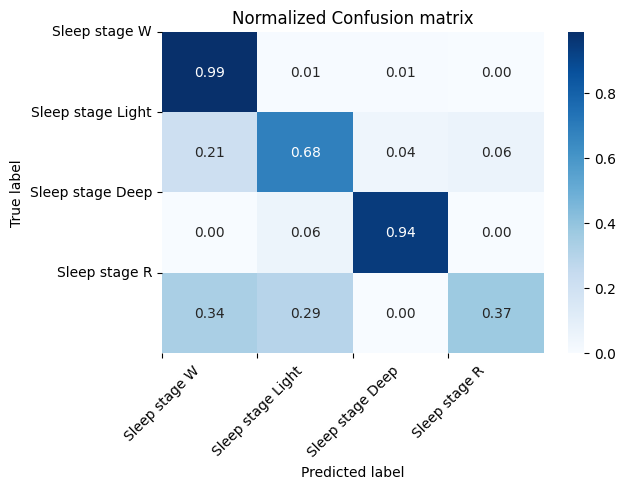

In [14]:
import seaborn as sns
# Normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] #합이 1이 되록 각  데이터 스케일링

# Plot confusion matrix
fig, ax = plt.subplots(1)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=event_id.keys(), yticklabels=event_id.keys(), cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
tick_marks = np.arange(len(event_id.keys()))
plt.xticks(tick_marks, event_id.keys(), rotation=45)
plt.yticks(tick_marks, event_id.keys())
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')

plt.show()

## Exercise

Fetch 50 subjects from the Physionet database and run a 5-fold
cross-validation leaving each time 10 subjects out in the test set.

## References
.. footbibliography::

